# Objectif : Prédire le prix médian des habitations dans un district

# Les modules necéssaires

In [194]:
# importation des modules nécéssaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score

In [4]:
# Définir le style des graphiques
sns.set(style="whitegrid")

In [6]:
# Ignorer les warnings
import warnings 
warnings.filterwarnings('ignore')

In [8]:
# Set font size for all plots
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Fonction pour le Chargement des données

In [49]:
def load_data(file_path, file_type='csv'):
    """
    Charge les données à partir d'un fichier spécifié.
    
    :param file_path: Chemin vers le fichier de données.
    :param file_type: Type de fichier ('csv', 'excel', 'json', 'sql'). Par défaut 'csv'.
    :return: DataFrame contenant les données chargées.
    """
    if file_type == 'csv':
        return pd.read_csv(file_path)
    elif file_type == 'excel':
        return pd.read_excel(file_path)
    elif file_type == 'json':
        return pd.read_json(file_path)
    elif file_type == 'sql':
        import sqlite3
        conn = sqlite3.connect(file_path)
        query = "SELECT * FROM table_name"  
        return pd.read_sql_query(query, conn)
    else:
        raise ValueError("Type de fichier non supporté: {}".format(file_type))

# Exemple d'utilisation
HousingData = load_data('HousingData.csv')
# HousingData = load_data('HousingData.xlsx', file_type='excel')
#data_json = load_data('data.json', file_type='json')
#data_sql = load_data('database.db', file_type='sql')


# Analyse exploratoire des données

In [12]:
# Un aperçu des données
HousingData.sample(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
1758,-118.42,33.92,25.0,3521.0,852.0,1524.0,764.0,3.8086,361300.0,<1H OCEAN
5250,-122.26,38.11,52.0,1560.0,353.0,670.0,287.0,1.7411,98400.0,NEAR BAY
19422,-122.67,38.45,24.0,2622.0,525.0,1027.0,510.0,2.9222,242600.0,<1H OCEAN
7397,-118.10,33.83,36.0,2000.0,343.0,956.0,352.0,5.3735,234400.0,<1H OCEAN
1877,-118.08,34.08,43.0,1716.0,402.0,1343.0,386.0,2.9688,211400.0,<1H OCEAN
15548,-117.96,34.02,33.0,349.0,124.0,460.0,83.0,2.3750,133300.0,<1H OCEAN
15594,-122.25,38.12,47.0,1339.0,298.0,794.0,286.0,2.5865,109800.0,NEAR BAY
2238,-118.29,34.08,34.0,479.0,182.0,557.0,170.0,1.5250,210000.0,<1H OCEAN
13276,-118.32,34.07,52.0,2156.0,306.0,861.0,311.0,8.8062,500001.0,<1H OCEAN
19722,-117.55,34.25,39.0,1578.0,317.0,872.0,322.0,4.5550,153100.0,INLAND


In [16]:
# Taille de notre jeu de donnés
HousingData.shape

(20640, 10)

In [170]:
# Je vérifie s'il y a des valeurs manquantes dans mon jeu de données
HousingData.isnull().sum().sum()

207

In [146]:
# valeurs manquantes
df_missing = pd.DataFrame({})
df_missing["Variables"] = HousingData.columns
df_missing["Nb de valeurs manquantes"] = [i for i in HousingData.isnull().sum()]
df_missing["% de valeurs manquantes"] = [round(i/HousingData.shape[0], 2)*100 for i in HousingData.isnull().sum()]
df_missing["Nb de valeurs unique"] = [i for i in HousingData.nunique()]
df_missing["Types de la variable"]= [i for i in HousingData.dtypes] 

# Affichage du tableau
df_missing.sort_values(by='% de valeurs manquantes', ascending=False)

,Variables,Nb de valeurs manquantes,% de valeurs manquantes,Nb de valeurs unique,Types de la variable
4,total_bedrooms,207,1.0,1923,float64
0,longitude,0,0.0,844,float64
1,latitude,0,0.0,862,float64
2,housing_median_age,0,0.0,52,float64
3,total_rooms,0,0.0,5926,float64
5,population,0,0.0,3888,float64
6,households,0,0.0,1815,float64
7,median_income,0,0.0,12928,float64
8,median_house_value,0,0.0,3842,float64
9,ocean_proximity,0,0.0,5,object


# Commentaires

- Nous constatons que la variable total_bedrooms contient des valeurs manquantes. Nous devons donc la traiter. 
- Les variables total_bedrooms et total_rooms doivent être de type entier et non des float. On effet, on ne peut pas avoir 4.2 chambre. Nous devons donc changer le type de ces variables. 

In [132]:
# Résumé sur les variables numériques
HousingData.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# Data preprocessing

In [15]:
# Nous verifions s'il y a des données dupliquées
HousingData.duplicated().any()

False

In [51]:
# Suppression des observations dont total_bedrooms à des valeurs manquantes.
HousingData = HousingData.dropna(axis=0, how='any')
HousingData.shape

(20433, 10)

#### Commentaires

Nous avons choisi de supprimer les observations ayant des valeurs manquantes au lieu de procéder à une imputation car nous sommes partisants de travailler avec des données originales. Aussi nous estimons que le pourcentage d'observations ayant des valeurs manquantes est faible : 1% et qu'une suppression n'aurait pas un grand effet sur la taille des données. 

In [53]:
# Changement du type des variables total_bedrooms et total_rooms

col = ['total_bedrooms','total_rooms']

for i in col:
    HousingData[i] = HousingData[i].astype(int)
    
HousingData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  int64  
 4   total_bedrooms      20433 non-null  int64  
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(7), int64(2), object(1)
memory usage: 1.7+ MB


<AxesSubplot:title={'center':'Distribution de la variable median_house_value)'}, xlabel='median_house_value', ylabel='Density'>

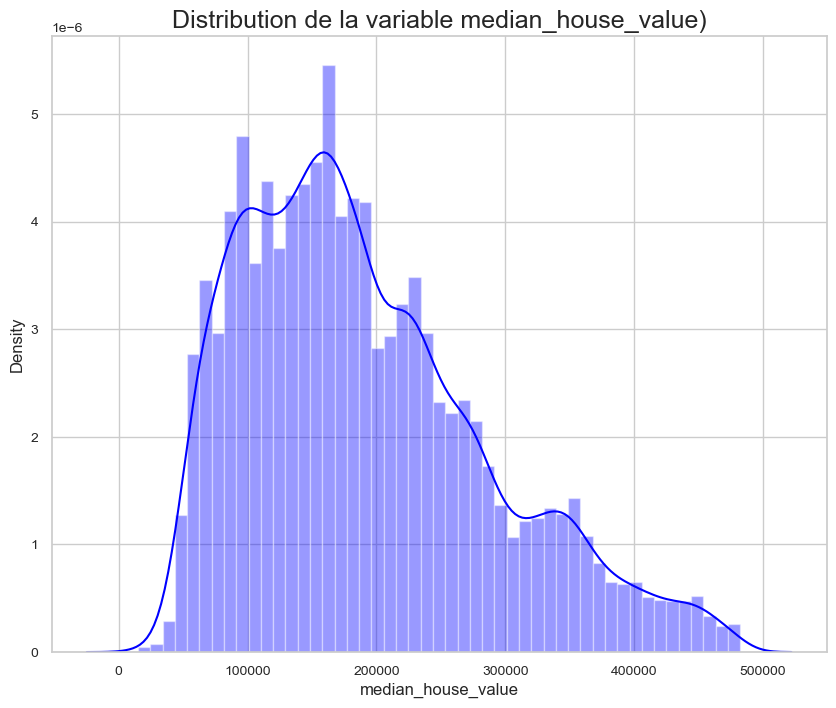

In [95]:
# Plotting distribution of Time feature
plt.figure(figsize=(10,8), )
plt.title('Distribution de la variable median_house_value)')
sns.distplot(HousingData['median_house_value'], color='blue')

<AxesSubplot:title={'center':'Repartition selon la longitude et la latitude'}, xlabel='longitude', ylabel='latitude'>

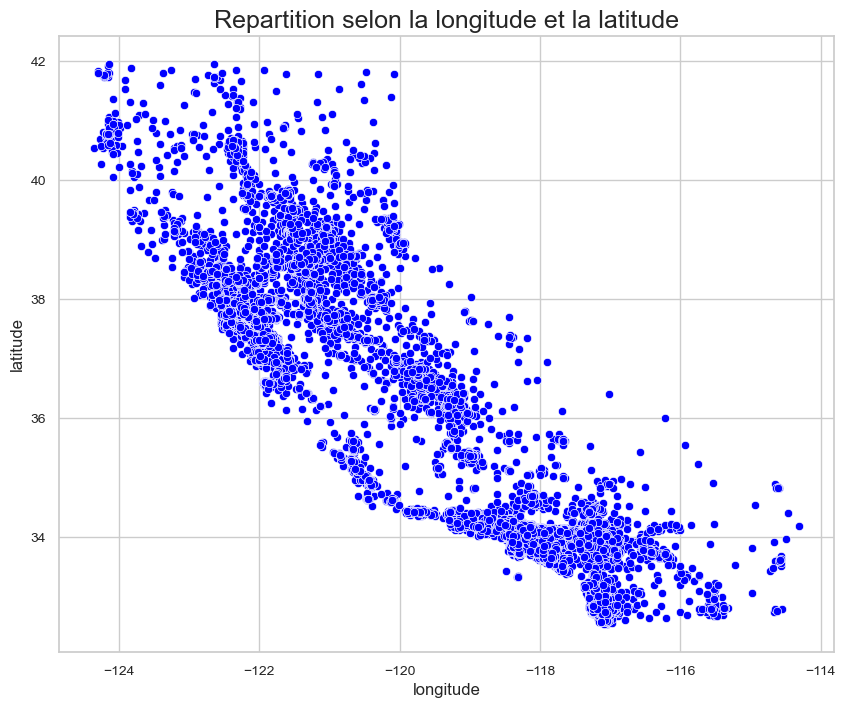

In [23]:
# Plotting distribution of Time feature
plt.figure(figsize=(10,8), )
plt.title('Repartition selon la longitude et la latitude')
sns.scatterplot(x=HousingData['longitude'], y= HousingData['latitude'], color='blue')

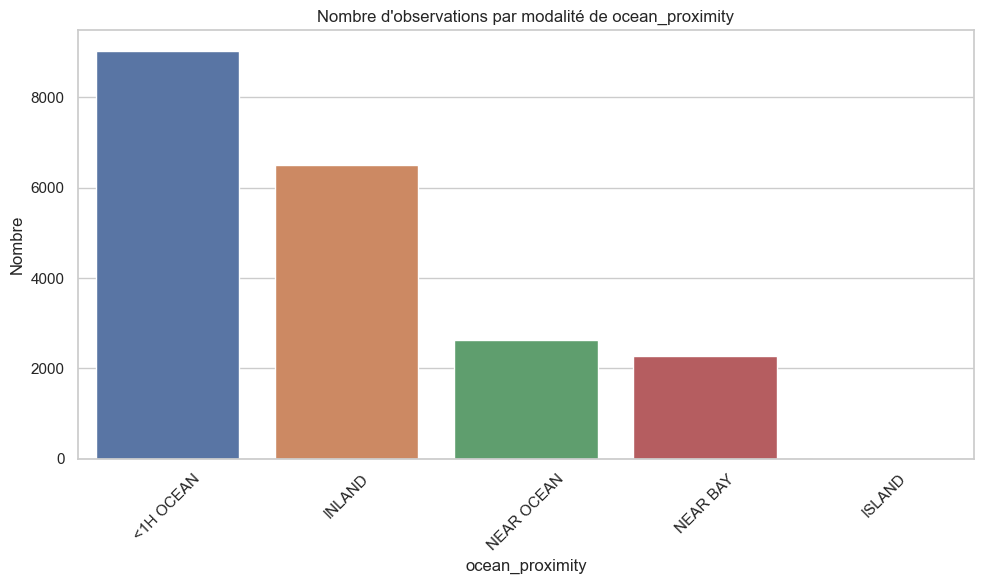

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Définir le style de seaborn
sns.set(style="whitegrid")

# Compter les valeurs de la variable ocean_proximity
ocean_proximity_counts = HousingData['ocean_proximity'].value_counts()

# Créer le graphique en barres
plt.figure(figsize=(10, 6))
sns.barplot(x=ocean_proximity_counts.index, y=ocean_proximity_counts.values)

# Ajouter des étiquettes et ajuster les paramètres du graphique
plt.title('Nombre d\'observations par modalité de ocean_proximity')
plt.xlabel('ocean_proximity')
plt.ylabel('Nombre')

# Afficher le graphique
plt.xticks(rotation=45)  # Rotation des étiquettes sur l'axe x pour une meilleure lisibilité
plt.tight_layout()  # Ajustement automatique de la disposition du graphique
plt.show()


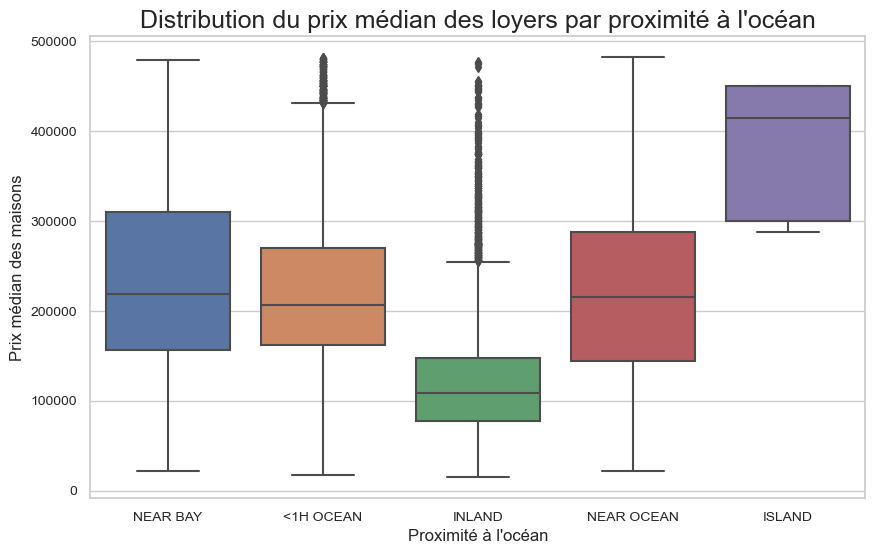

In [97]:
# Tracer le boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='ocean_proximity', y='median_house_value', data=HousingData)
plt.title('Distribution du prix médian des loyers par proximité à l\'océan')
plt.xlabel('Proximité à l\'océan')
plt.ylabel('Prix médian des maisons')
plt.show()

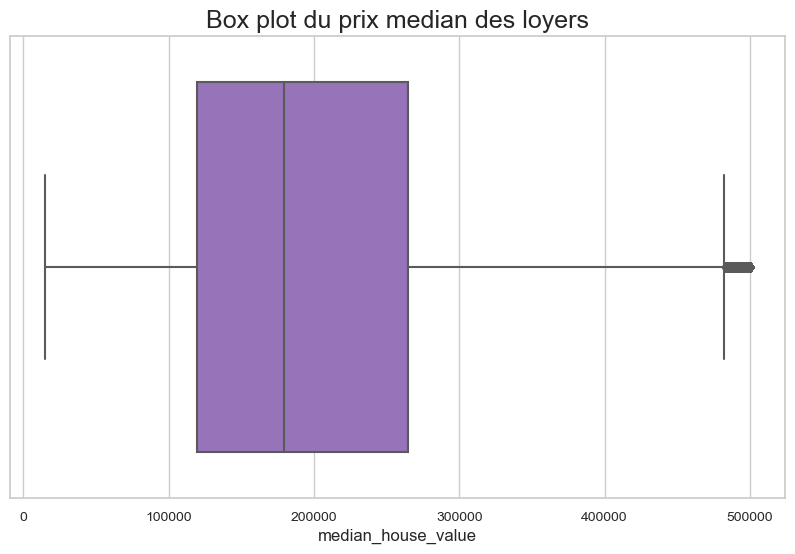

In [53]:
# Identification graphique des outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='median_house_value', data=HousingData, color ='#9867C5')
plt.title('Box plot du prix median des loyers')
plt.xlabel('median_house_value')
plt.show()

#### Commentaire
Le graphique nous indique une présence de valeurs extrêmes (aberrantes) : valeurs > ~ 4700000. Nous devons donc prodéder au traitement de ces valeurs aberantes

In [22]:
# Gestion des valeurs aberrantes : Calcul pour détecter les valeurs abérantes

In [55]:
# Calcul des quartiles et de l'EIQ
Q1=HousingData['median_house_value'].quantile(0.25)
Q3=HousingData['median_house_value'].quantile(0.75)
EIQ= Q3-Q1

# Calcul des bornes pour les outliers
BI=Q1-1.5*EIQ
BS=Q3+1.5*EIQ

In [57]:
# Affichage des données avec des valeurs abérantes
HousingData_aberrantes = HousingData[(HousingData["median_house_value"] > BS) | (HousingData["median_house_value"] < BI)]
HousingData_aberrantes

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
89,-122.27,37.80,52.0,249.0,78.0,396.0,85.0,1.2434,500001.0,NEAR BAY
103,-118.47,33.99,24.0,1438.0,454.0,665.0,416.0,2.9750,500001.0,<1H OCEAN
105,-118.50,33.97,29.0,2737.0,808.0,1157.0,696.0,5.1280,500001.0,<1H OCEAN
107,-118.39,34.08,27.0,6605.0,1710.0,2665.0,1520.0,3.8088,500001.0,<1H OCEAN
132,-122.34,37.55,44.0,2465.0,328.0,843.0,324.0,6.9533,500001.0,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...,...
20494,-118.12,34.13,52.0,2935.0,341.0,975.0,327.0,11.7060,500001.0,<1H OCEAN
20500,-121.93,37.66,24.0,3166.0,424.0,1081.0,400.0,8.3337,500001.0,<1H OCEAN
20511,-122.05,37.31,25.0,4111.0,538.0,1585.0,568.0,9.2298,500001.0,<1H OCEAN
20515,-117.36,33.17,24.0,2046.0,442.0,812.0,367.0,2.3182,500001.0,NEAR OCEAN


In [77]:
# Nous verrifions le min
min(HousingData_aberrantes["median_house_value"])

482700.0

In [79]:
# Nous verrifions le max
max(HousingData_aberrantes["median_house_value"])

500001.0

In [59]:
# Données sans valeurs abérantes
HousingData_sans_aberrantes = HousingData[(HousingData["median_house_value"] <= BS) & (HousingData["median_house_value"] >= BI)]
HousingData_sans_aberrantes

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [85]:
# Nous affectons HousingData_sans_aberrantes a HousingData
HousingData = HousingData_sans_aberrantes

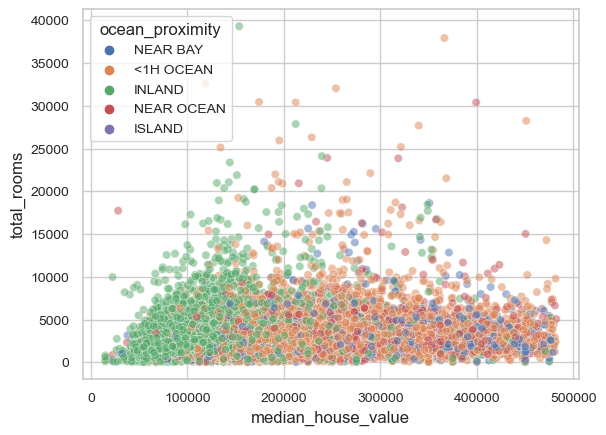

In [87]:
sns.scatterplot(x='median_house_value', y='total_rooms', data = HousingData, alpha = 0.5, hue = 'ocean_proximity')
plt.show()

<AxesSubplot:>

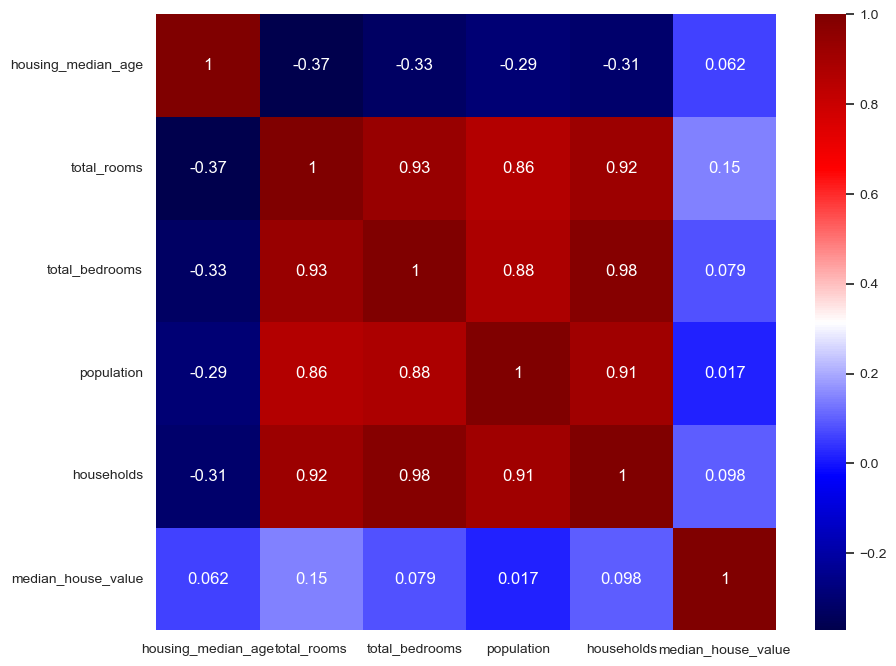

In [89]:
# Heatmap : Corrélation entre les variables. 

df = HousingData[["housing_median_age","total_rooms","total_bedrooms","population","households","median_house_value"]]
# Plotting heatmap to find any high correlations between variables
plt.figure(figsize=(10,8))
sns.heatmap(data=df.corr(), cmap="seismic", annot=True) 
# plt.show()

Avec la matrice de corrélation, nous pouvons dire qu'il n'y a pas une forte corrélation positive ni négative entre le prix median des loyers et les autres variables. Il n'y aura à priori pas de problème de multicolinéarité lors de la construction des modèles. Toutes les variables peuvent donc être conservées. 

# Feature Engineering

In [99]:
# Dummie sur la variable ocean_proximity
pd.get_dummies(HousingData['ocean_proximity']).head()

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


In [101]:
# Concaetnation de la Dummie variable avec le reste du jeu de donnée. 
df = pd.concat([pd.get_dummies(HousingData['ocean_proximity']), HousingData], axis=1)

In [103]:
# Suppression des variables unitiles
var_utiles = [feat for feat in list(df) if feat not in ['ocean_proximity']] 
df = df[var_utiles]

In [105]:
df.sample(5)

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
13974,1,0,0,0,0,-121.68,37.00,19.0,3754.0,588.0,1692.0,550.0,6.7644,412600.0
3169,1,0,0,0,0,-118.34,33.90,23.0,2395.0,498.0,1309.0,493.0,4.9779,224600.0
1921,0,1,0,0,0,-121.27,37.88,43.0,968.0,249.0,664.0,240.0,1.6458,83600.0
1592,1,0,0,0,0,-122.76,38.44,14.0,4376.0,797.0,1809.0,746.0,3.8244,180000.0
6153,1,0,0,0,0,-118.52,34.25,11.0,7849.0,1664.0,3561.0,1500.0,4.6625,290900.0


# La partie Modélisation

In [107]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor


In [109]:
# Diviser le dataset en X et y

X = df.iloc[:, :-1].values 
y = df.iloc[:, -1].values

In [111]:
# Diviser le dataset entre le Training set et le Test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [113]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [117]:
# Construction de plusieurs modèles
models = []
models.append(('Linear Regression', LinearRegression())) 
models.append(('Ridge Regression', Ridge())) 
models.append(('Lasso Regression', Lasso())) 
models.append(('ElasticNet', ElasticNet())) 
models.append(('KNN Regression', KNeighborsRegressor())) 
models.append(('Decision Tree', DecisionTreeRegressor())) 
models.append(('Random Forest', RandomForestRegressor())) 
models.append(('Gradient Boosting', GradientBoostingRegressor())) 
models.append(('SVR', SVR())) 
models.append(('MLP Regressor', MLPRegressor(max_iter=1000)))

results = []
names = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
    cv_result = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    names.append(name)
    results.append(cv_result)
    
# Stocker les résultats dans une liste de dictionnaires
model_results = []   
for i in range(len(names)):    
    model_results.append({'modèle': names[i], 'score': abs(results[i].mean())}) # Donne le MSE réel. Prendre donc le modèle qui a le plus faible MSE. 
    
# Convertir en DataFrame
r = pd.DataFrame(model_results)

# Trier par score
r = r.sort_values(by='score', ascending=True)

# Afficher le DataFrame trié
r

              modèle         score
6      Random Forest  1.936928e+09
7  Gradient Boosting  2.391695e+09
4     KNN Regression  2.935139e+09
0  Linear Regression  3.484116e+09
1   Ridge Regression  3.484575e+09
2   Lasso Regression  3.484600e+09
5      Decision Tree  3.824980e+09
9      MLP Regressor  3.948829e+09
3         ElasticNet  4.178266e+09
8                SVR  9.309669e+09


In [180]:
# Choix d'un modèle
rf = RandomForestRegressor() 
rf.fit(X_train, y_train)

RandomForestRegressor()

In [181]:
# Prédiction
y_pred = rf.predict(X_test)

In [182]:
y_pred[:20]

array([154558., 138903., 117555., 170668., 259033.,  79039., 176549.,
        69809., 119297., 196832., 251759., 303351., 172054., 205945.,
       324581., 109112., 162574., 103276., 267722.,  59838.])

In [186]:
y_train[:20]

array([112300., 202100., 355500., 224700., 131500., 322300.,  55000.,
       110700., 322300., 238600., 207200., 159600., 151400., 337500.,
       362500., 267400., 185100., 223700., 139100., 129200.])

In [208]:
# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

Mean Squared Error: 1956857890.3491342
R-squared: 0.7865631382068177


In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming regressor is your trained Random Forest model
# Pick one tree from the forest, e.g., the first tree (index 0)
tree_to_plot = rf.estimators_[0]

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, feature_names=df.columns.tolist(), filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree from Random Forest")
plt.show()


In [219]:
# Affichage des varibales les plus importantes
feature_importances = pd.DataFrame(rf.feature_importances_, index = df.iloc[:, :-1].columns,columns = ['importance']).sort_values('importance', ascending=False)
                                   
feature_importances

,importance
median_income,0.434772
INLAND,0.160855
longitude,0.121666
latitude,0.111616
housing_median_age,0.047262
population,0.036152
total_rooms,0.029383
total_bedrooms,0.024462
households,0.022994
NEAR OCEAN,0.006878
